# Preamble

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation
from mpl_toolkits import mplot3d
from scipy import optimize

# Study case

<IPython.core.display.Javascript object>


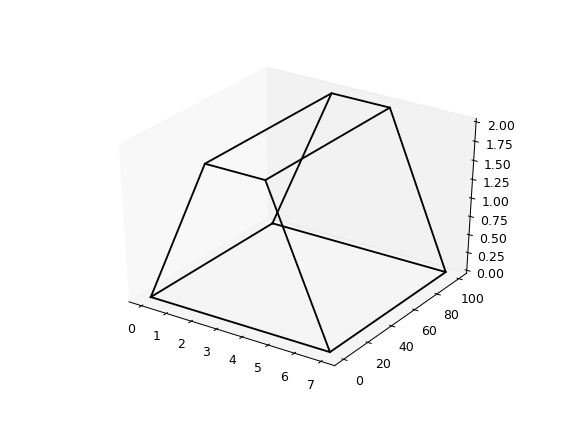

In [12]:
alpha = 40
b = 7
h = 2
l = 100
b2 = h*np.tan(np.deg2rad(90-alpha))

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.grid(False)
def plot_pile(b,b2,h,l,c):
    ax.plot([0,b2,b-b2,b,0],[l,l,l,l,l],[0,h,h,0,0],c=c)
    ax.plot([0,b2,b-b2,b,0],[0,0,0,0,0],[0,h,h,0,0],c=c)
    ax.plot([0,0],[0,l],[0,0],c=c)
    ax.plot([b2,b2],[0,l],[h,h],c=c)
    ax.plot([b-b2,b-b2],[0,l],[h,h],c=c)
    ax.plot([b,b],[0,l],[0,0],c=c)
plot_pile(b,b2,h,l,'k')

In [128]:
def vol(alpha, b, h, l):
    b2 = h*np.tan(np.deg2rad(90-alpha))
    frontArea = h*(b+b2)/2
    totalArea = frontArea*l
    return totalArea

In [122]:
fixedVol = 10000

In [129]:
fVol = lambda l, b, h, alpha, fixedVol : vol(alpha, b, h, l)-fixedVol

In [130]:
optimize.fsolve(fVol, 0, args=(b, h, alpha, fixedVol))

array([1065.69961557])

In [165]:
alphaL = np.linspace(1,89,10)
bL = np.linspace(1,10,10)
hL = np.linspace(1,5,10)

In [166]:
data = np.zeros((len(alphaL)*len(bL)*len(hL),2))
ite = 0
for i in range(len(alphaL)):
    for j in range(len(bL)):
        for k in range(len(hL)):
            L = optimize.fsolve(fVol, 0, args=(bL[j], hL[k], alphaL[i], fixedVol))
            b2 = hL[k]*np.tan(np.deg2rad(90-alphaL[i]))
            side = np.sqrt(b2**2+hL[k]**2)
            data[ite, 0] = bL[j]*L
            data[ite, 1] = 2*(hL[k]*(bL[j]+b2)/2+side*L)+b2*L
            ite += 1

<IPython.core.display.Javascript object>


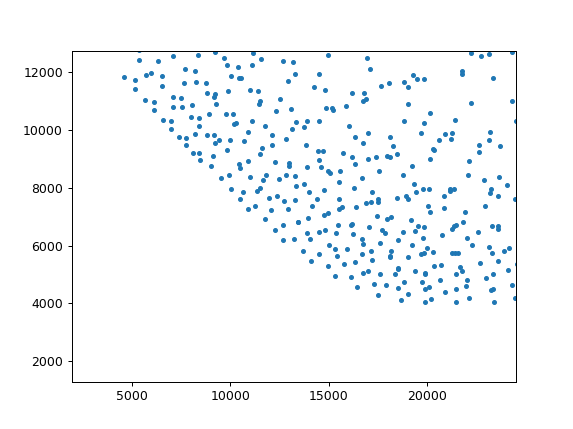

In [176]:
fig, ax = plt.subplots()
plt.plot(4*data[:,0]+data[:,1].min(),data[:,1],'.')

In [180]:
dataSum = 4*data[:,0]+data[:,1].min()+data[:,1]

In [181]:
data[dataSum.argmin(),:]

array([  146.70144719, 11834.61363325])

<IPython.core.display.Javascript object>


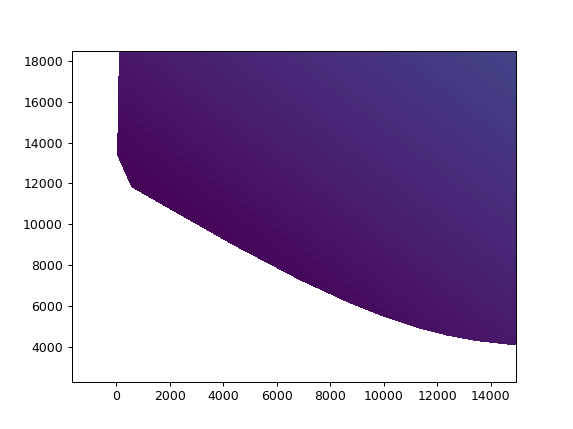

In [185]:
fig, ax = plt.subplots()
plt.tricontourf(4*data[:,0],data[:,1],dataSum,levels=200)

## DATA adquisition

In [15]:
data = np.genfromtxt('global_radiation.txt', delimiter='', skip_header = 14, unpack=True, dtype=float)

mask = np.where(np.logical_and(data[0,:] == 44, data[1,:] == -73))
Solar_radiation = np.zeros(12)
for i in range(2,10):
    Solar_radiation[i] = data[i+2,mask]
Solar_radiation = Solar_radiation[Solar_radiation != 0.]*3600/1000

OSError: global_radiation.txt not found.

In [30]:
# Get the values and remove the non valids
dailyWd = np.genfromtxt('weatherData.txt', usecols=(0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19), delimiter=' ')
dailyWd[np.isnan(dailyWd)] = 0

# Preallocation
wD = np.zeros((int(len(dailyWd)/30.),dailyWd.shape[1]))

# Get the monthly mean
for i in range(len(wD)):
    wD[i,:] = np.mean(dailyWd[30*i:30*(i+1),:], axis=0)
    
  # Headers  
# 2017 	Temp. (°C) 	Punto de rocío (°C) 	Humedad (%) 	Sea Level Press. (hPa) 	Visibilidad (km) 	Wind (km/h) 	Precip. (mm) 	Eventos
# Oct 	high 	avg 	low 	high 	avg 	low 	high 	avg 	low 	high 	avg 	low 	high 	avg 	low 	high 	avg 	high 	sum 	 

In [31]:
dailyWd

array([[  1.  ,  16.  ,  11.  , ...,   8.  ,  53.  ,   3.81],
       [  2.  ,  11.  ,   1.  , ...,  16.  ,  53.  ,   0.  ],
       [  3.  ,  -6.  , -10.  , ...,  14.  ,  47.  ,   0.  ],
       ...,
       [ 28.  ,   7.  ,  -5.  , ...,   9.  ,  34.  ,   0.  ],
       [ 29.  ,   9.  ,   2.  , ...,  11.  ,  58.  ,   3.81],
       [ 30.  ,   4.  ,  -2.  , ...,   9.  ,  40.  ,   4.06]])

In [14]:
clouds = 1-np.array([0.51, 0.49, 0.56, 0.59, 0.64, 0.60, 0.54, 0.47, 0.31])

T_sky = np.zeros(8)
e_cloud = np.zeros(8)

for i in range (8):
    e_cloud[i] = (1-.84*clouds[i])*(0.527 + 0.161*np.exp(8.45*(1-(273/(wD[i,2]))))) + 0.84*clouds[i]
    T_sky[i] = ((9.365574e-6)*(1-clouds[i])*(wD[i,2])**6 + e_cloud[i]*clouds[i]*(wD[i,2])**4)**.25

NameError: name 'wD' is not defined

In [17]:
Pond_543 = pd.read_csv("data1.csv", squeeze=True, parse_dates=[0], index_col=[0],
                      header = 1, names = ["p50cm", "p1m"])
Pond_544 = pd.read_csv("data2.csv", squeeze=True, parse_dates=[0], index_col=[0],
                      header = 1, names = ["p5cm", "p20cm"])

NameError: name 'pd' is not defined